# SNODAS vs CSO

This script extracts point data from the [NASA snodas dataset](https://nsidc.org/data/g02158) at the location of CSOs.

We're aware of a few other repos that overlap with this work:

* David Hill's [matlab and shell scripts](https://github.com/dfosterhill/SNODAS)
* David Shean's [Python snowtools](https://github.com/dshean/snowtools)

This script calls the [MountainHub API](https://github.com/communitysnowobs/mountainhub-api) 

### Authors

* Jonah Joughin 
* Anthony Arendt 
* Emilio Mayorga

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
from datetime import datetime
import seaborn as sns
from tqdm import tqdm

from validation import SNODAS, Elevation, utils as ut, creds
import mtnhubsnow as mh

## Download CSO 

In [11]:
# Restrict points to the coterminous US
region = {
    'latmax' : 50,
    'latmin' : 25,
    'lonmax': -65,
    'lonmin': -125,
}

obs = mh.snow_data(limit=1000, start=datetime(2017,10,1), end=datetime(2018,4,30), bbox=region)
obs['date'] = obs.apply(lambda row: datetime.fromisoformat(row['datetime_utc'].strftime('%Y-%m-%d')), axis=1)
obs.sort_values(by=['date'], inplace = True)
obs.head()

,id,datetime_utc,latitude,longitude,author_name,obs_type,snow_depth,description,date
571,59e42113e2ee090b1c2ed009,2017-10-14 23:00:00+00:00,43.507211,-110.948868,Jacob Urban,snow_conditions,45.000000,Not enough snow to make safe turns. Weak basal...,2017-10-14
570,5bfc6c771a711306b450d208,2017-10-15 19:00:00+00:00,44.401997,-121.882284,David Hill,snow_conditions,43.180000,,2017-10-15
569,59e40df6e2ee090b1c0aeb47,2017-10-16 01:40:02.297000+00:00,46.230208,-122.150324,GoatSolo,snow_conditions,15.240000,,2017-10-16
564,59eab71a3a0c020b158f8e62,2017-10-21 02:55:05.614000+00:00,39.749913,-105.873374,Ryo Sueda,snow_conditions,35.559999,,2017-10-21
566,59eab3353ccff80b07dddd98,2017-10-21 02:38:44.385000+00:00,39.774098,-105.889726,Ryo Sueda,snow_conditions,25.400000,Deepest part was about 1.5 feet. only around 4...,2017-10-21


In [ ]:
grouped = obs.groupby('date')
snodas_hs = []
n = 1
# this is to show progress over the iterations
pbar = tqdm(grouped)
for name, group in pbar:
    # get the snowdas data for each day
    date = datetime.utcfromtimestamp(group['date'].values[0].tolist()/1e9)
    pbar.set_description('processing {}, {} of {} dates'.format(date.strftime("%Y-%m-%d"), n, len(grouped)))
    ds = SNODAS.snodas_ds(date)
    tgt_x = xr.DataArray(group['longitude'].values, dims="points")
    tgt_y = xr.DataArray(group['latitude'].values, dims="points")
    for i in range(len(tgt_x)):
        snodas_hs.append(ds.sel(x=tgt_x, y=tgt_y, method='nearest').values[0][i]/1000)
    n += 1

processing 2018-02-08, 84 of 142 dates:  58%|█████▊    | 83/142 [17:21<15:29, 15.76s/it]

## Combine results into a new dataframe

In [4]:
df = pd.DataFrame({"longitude":obs.longitude,
                   "latitude":obs.latitude, 
                   "date":obs.date,
                   "CSO_hs": obs.snow_depth.values/100, # convert from cm to m
                   "snodas_hs": snodas_hs})

## Make a scatter plot of the data

<AxesSubplot:xlabel='CSO_hs', ylabel='snodas_hs'>

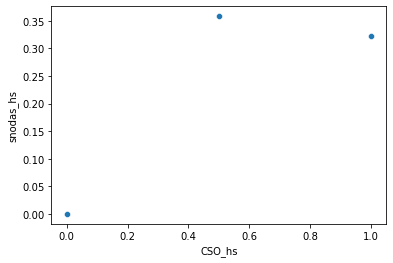

In [5]:
sns.scatterplot(x="CSO_hs",y="snodas_hs", data=df)